This is the same script as DMML2_project_pepper_hyperparameters.ipynb but to be run locally\

In [3]:
import pandas as pd
import os
import cv2
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow import keras
from keras import metrics

import matplotlib.colors as mcolors
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense


from keras.optimizers import Adam
from keras.preprocessing import image

import matplotlib.pyplot as plt
from keras import models
from keras import preprocessing
#import keras_tuner as kt
from PIL import Image
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
print("Done importing packages!")

Done importing packages!


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (240, 240)

In [13]:

data_dir = "PlanDoc"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.28,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

### two validation subsets, one is actually the sample subset to be used to tune the parameters
validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.08,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)


test_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

print(train_dataset)


Found 1130 files belonging to 13 classes.
Using 814 files for training.
Found 1130 files belonging to 13 classes.
Using 90 files for validation.
Found 1130 files belonging to 13 classes.
Using 226 files for validation.
<BatchDataset element_spec=(TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None))>


In [14]:
class_names = validation_dataset.class_names
num_classes = len(class_names)
for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Apple___Apple_scab
2.  Apple___Cedar_apple_rust
3.  Apple___healthy
4.  Pepper__bell___Bacterial_spot
5.  Pepper__bell___healthy
6.  Tomato leaf yellow virus
7.  Tomato___Bacterial_spot
8.  Tomato___Early_blight
9.  Tomato___Late_blight
10.  Tomato___Leaf_Mold
11.  Tomato___Septoria_leaf_spot
12.  Tomato___Tomato_mosaic_virus
13.  Tomato___healthy


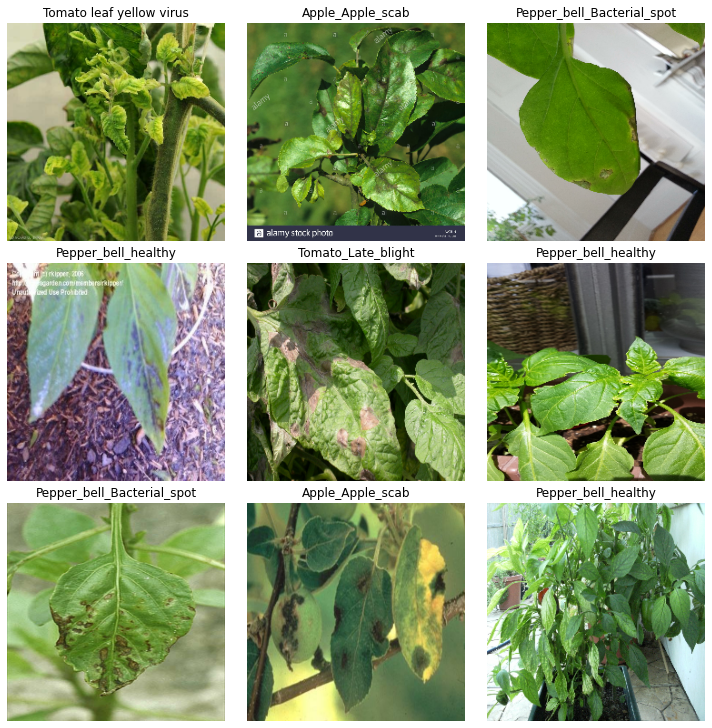

In [15]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

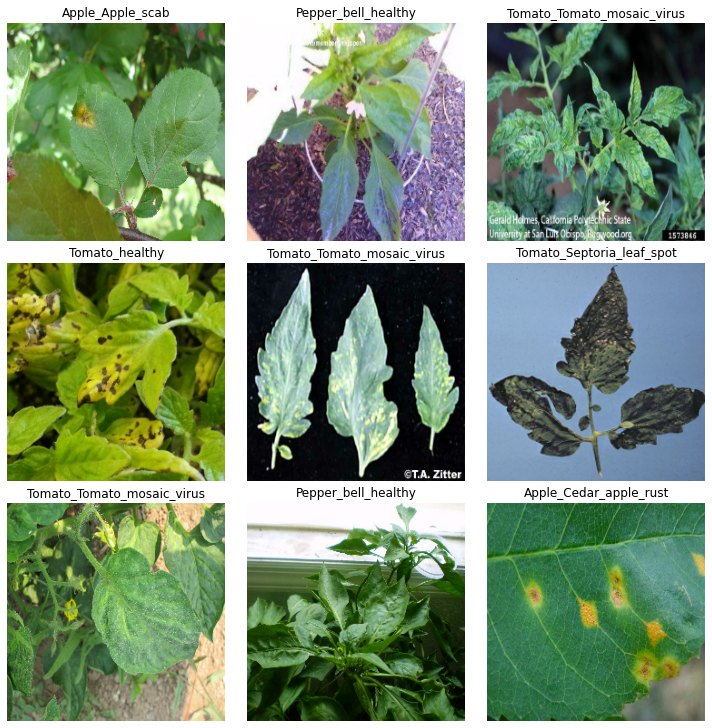

In [16]:
plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

In [17]:
print('Number of batches used to tune the parameters: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of batches used to tune the parameters: 6


In [18]:
AUTOTUNE = tf.data.AUTOTUNE
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [19]:
def plot_metrics(history):
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [20]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [21]:
IMG_SHAPE = IMG_SIZE + (3,)

In [22]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [23]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
base_model = tf.keras.applications.InceptionResNetV2(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE,
                            )

In [24]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 6, 6, 1536)


In [25]:
base_model.trainable = False

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(16, 1536)


In [27]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 13)


In [28]:
def model_builder(hp):
  inputs = tf.keras.Input(shape=(240, 240, 3))
  #x = data_augmentation(inputs)
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
# change the categorical crossentropy from logits to False, as the activation is softmax
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=1,
                     factor=3,
                     overwrite=True,
                     directory='DMML2_CA/hyper_tuner',
                     project_name='tuner1attempt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
#tuner.search(train_dataset, epochs=1, validation_data=validation_dataset, callbacks=[stop_early])
tuner.search(train_dataset, epochs=1, validation_data=validation_dataset)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset)

In [ ]:
eval_result = hypermodel.evaluate(validation_dataset)

print("[val loss, val accuracy]:", eval_result)

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

In [ ]:
initial_epochs = 10

In [ ]:
len(train_dataset)

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
plot_metrics(history)

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 700

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

In [ ]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
result = model.evaluate(test_dataset)

3/3 [==============================] - 25s 8s/step - loss: 0.0594 - accuracy: 0.9896


In [ ]:
result = model.evaluate(test_dataset_outdoor)

1/1 [==============================] - 7s 7s/step - loss: 0.2310 - accuracy: 0.9412


In [ ]:
result = model.evaluate(validation_dataset)

13/13 [==============================] - 101s 8s/step - loss: 0.0576 - accuracy: 0.9850


In [ ]:
print(len(test_dataset))

3


In [ ]:
print(len(validation_dataset))

13


In [ ]:
print(len(train_dataset))

62


In [ ]:
metrics = ["loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall", "auc"]
for i in range(len(result)):
    print("{} : {}".format(metrics[i],round(result[i], 3)))

loss : 0.035
tp : 288.0
fp : 5.0
tn : 3511.0
fn : 5.0
accuracy : 0.983
precision : 0.983
recall : 0.983
auc : 1.0


Predictions:
 [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Labels:
 [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]


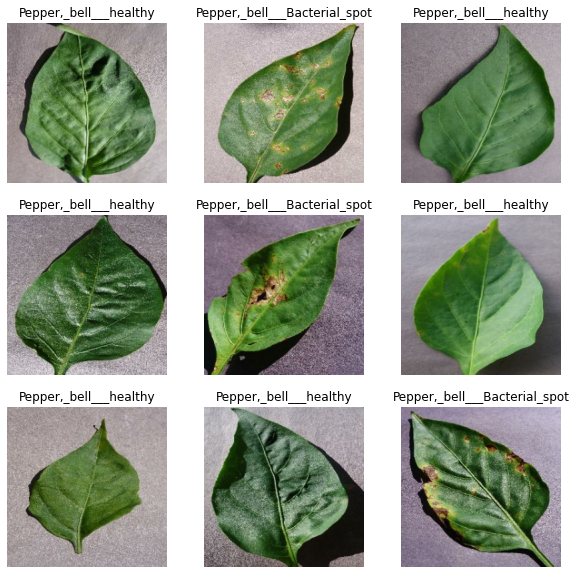

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
models.save_model(model, "./inception_v3")

INFO:tensorflow:Assets written to: ./inception_v3/assets


INFO:tensorflow:Assets written to: ./inception_v3/assets
